In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Fraud.csv')

# Data Preprocessing

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Data Cleaning

### Handling missing values

In [ ]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [ ]:
df.dropna(inplace=True)

### We identified a small number of rows with missing values in the dataset. Given the very large size of the dataset, these few rows were safely removed without impacting the overall data distribution

### Checking redundancy

In [ ]:
df.duplicated().sum()

np.int64(0)

### EDA

Transaction Distribution:
Non-Fraudulent: 6354407
Fraudulent: 8213 (0.1291%)


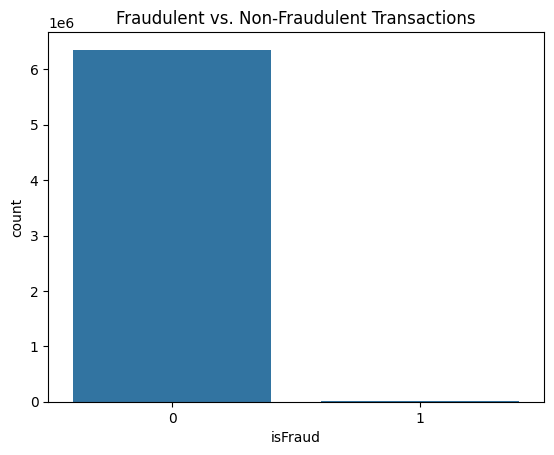

In [ ]:
# Analyze the distribution of the target variable 'isFraud'
fraud_counts = df['isFraud'].value_counts()
print("Transaction Distribution:")
print(f"Non-Fraudulent: {fraud_counts[0]}")
print(f"Fraudulent: {fraud_counts[1]} ({fraud_counts[1]/len(df)*100:.4f}%)")

sns.countplot(x='isFraud', data=df)
plt.title('Fraudulent vs. Non-Fraudulent Transactions')
plt.show()

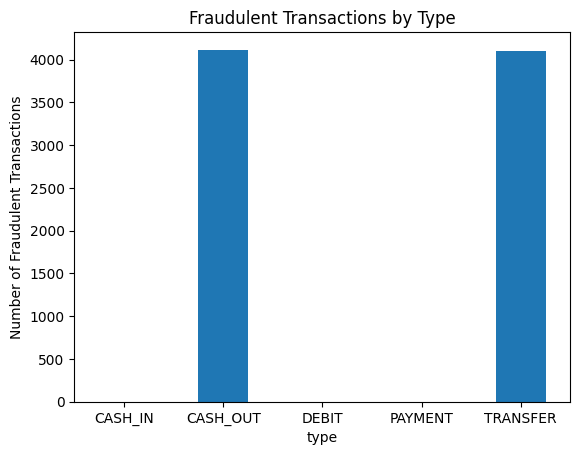

In [ ]:
# Transaction types involved in fraud
fraudulent_types = df.groupby('type')['isFraud'].sum()


fraudulent_types.plot(kind='bar')
plt.title('Fraudulent Transactions by Type')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=0)
plt.show()

### Identifying and handling outliers

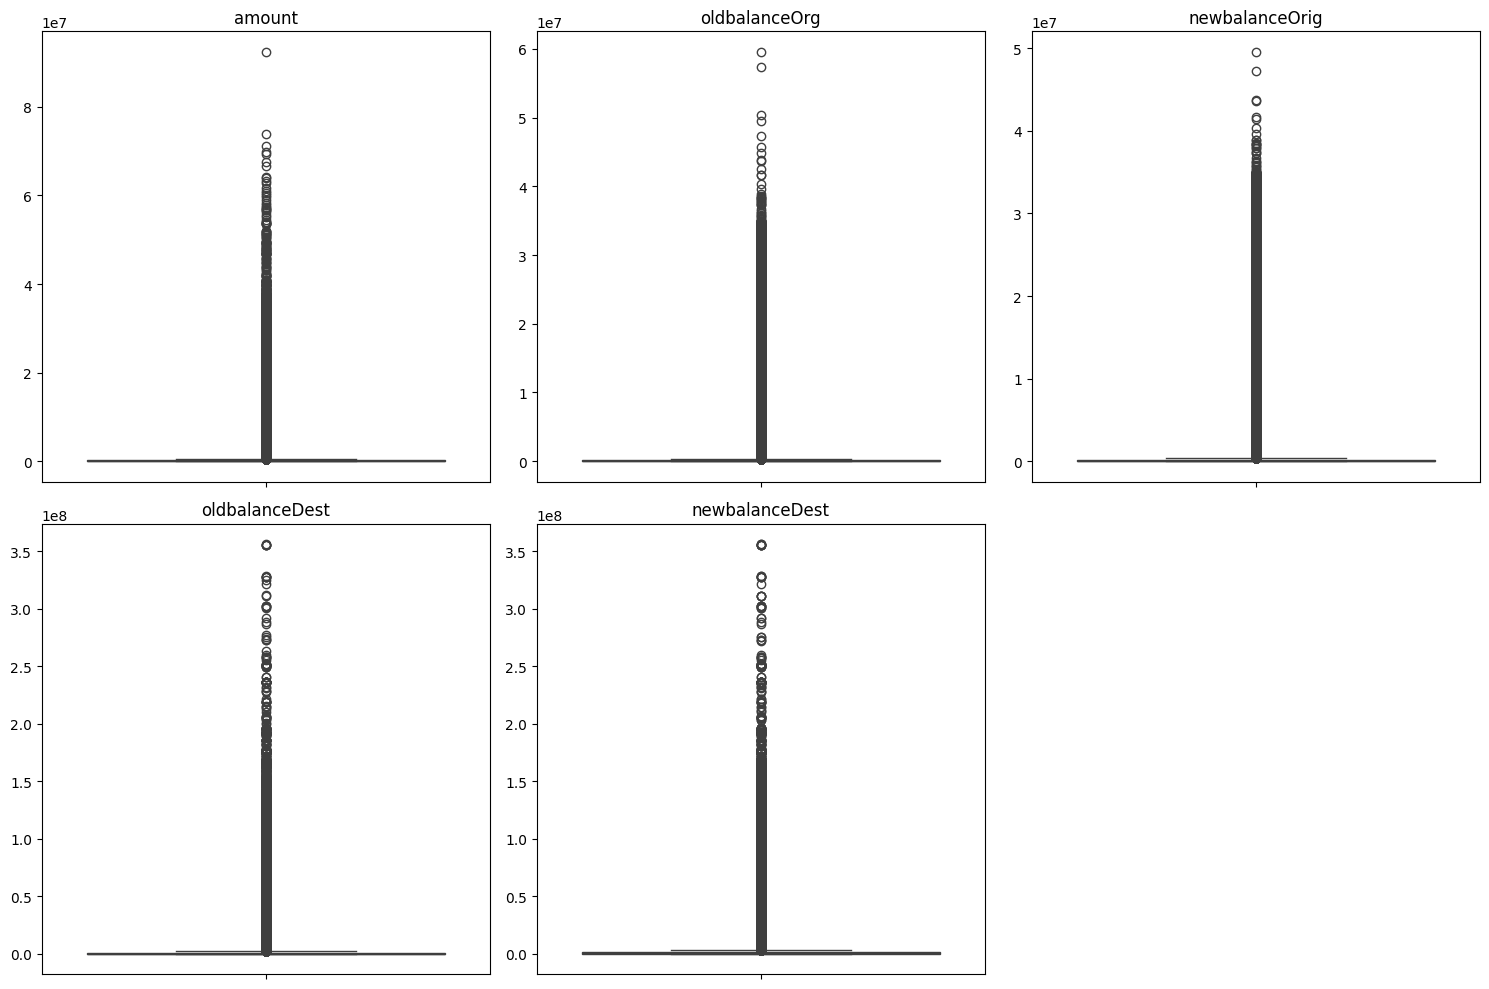

In [ ]:
# Identifying Outliers using boxplots

financial_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

plt.figure(figsize=(15, 10))

# Loop through the columns and create a boxplot for each
for i, col in enumerate(financial_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'{col}')
    plt.ylabel('')

plt.tight_layout()
plt.show()

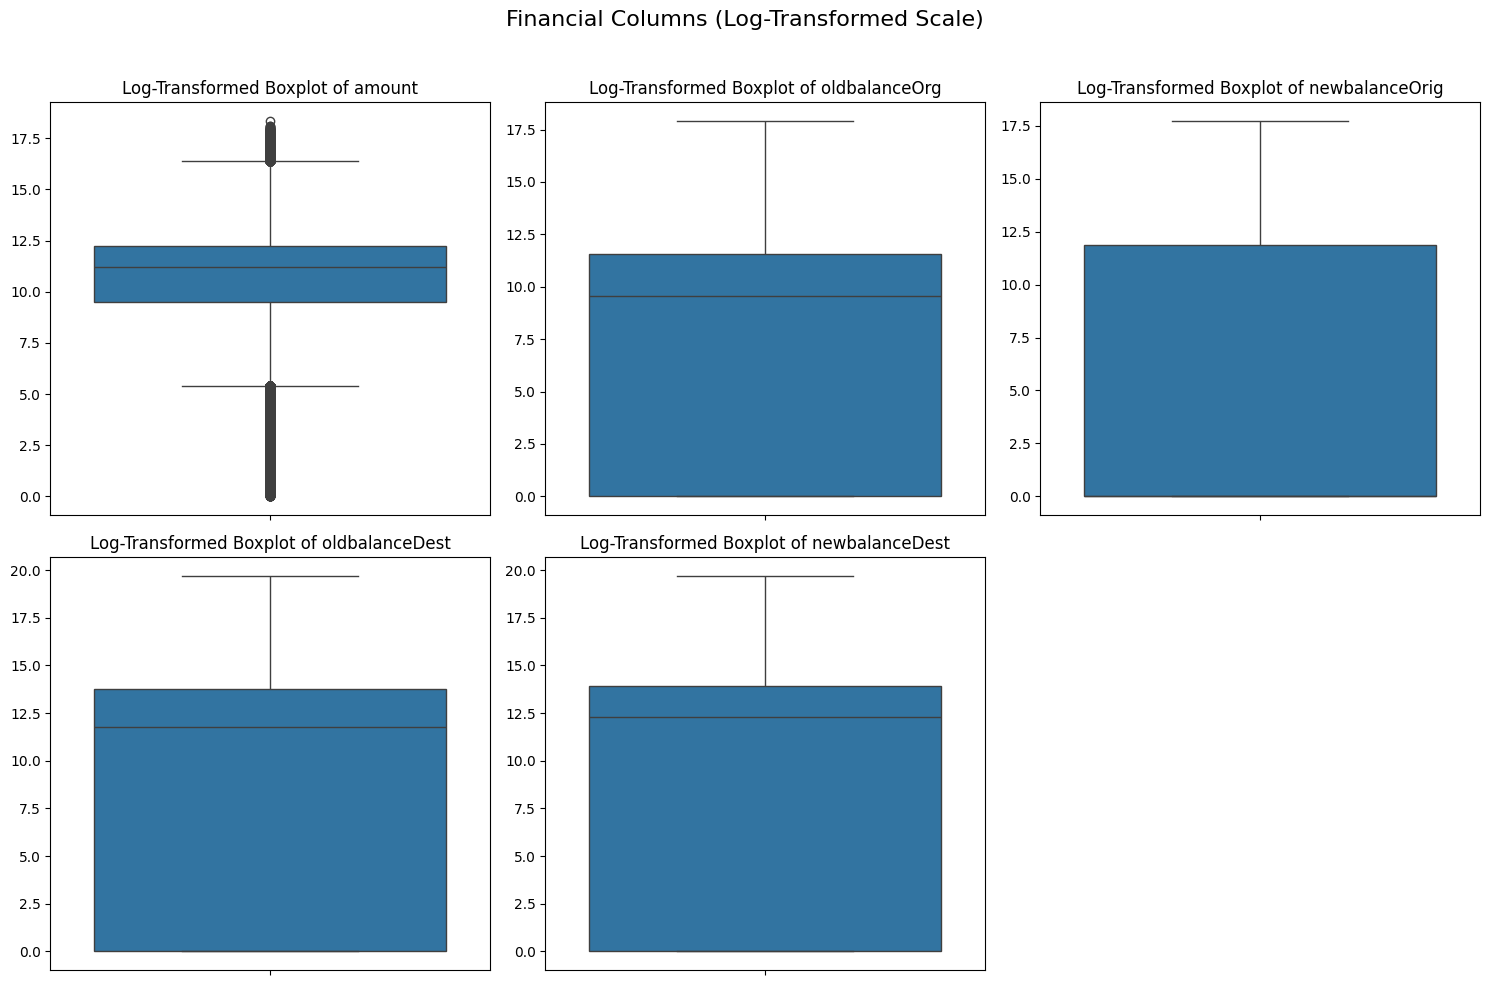

In [ ]:
df_log_transformed = df.copy()

plt.figure(figsize=(15, 10))
plt.suptitle("Financial Columns (Log-Transformed Scale)", fontsize=16)
for i, col in enumerate(financial_cols):
    df_log_transformed[col] = np.log1p(df[col])
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df_log_transformed[col])
    plt.title(f'Log-Transformed Boxplot of {col}')
    plt.ylabel('')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# In fraud detection, outliers are often the fraudulent transactions themselves. So instead of removing them, we keep them.

### We visualized outliers in financial columns like amount and account balances using boxplots. It was observed that the data contains many extreme values, which is typical for financial transactions. In the end, we did not remove these outliers, as fraudulent transactions are often outliers themselves. Removing them would mean throwing away the very data we want to detect. The analysis was for understanding the data's nature, not for cleaning.

### I did not explicitly handle multi-collinearity. This is because the our main model chosen, Random Forest, is an ensemble of decision trees and is naturally robust to multicollinearity. It can effectively select the best predictive features even when some are correlated. Similarly, Neural Networks can learn to assign lower weights to redundant features, solving the issue.

# Feature selection and engineering

In [ ]:
# A zero balance after a transaction can mean fraud

df['isOrigBalanceZero'] = (df['oldbalanceOrg'] == 0) & (df['newbalanceOrig'] == 0) & (df['amount'] != 0)
df['isDestBalanceZero'] = (df['oldbalanceDest'] == 0) & (df['newbalanceDest'] == 0) & (df['amount'] != 0)

# Create a feature for balance discrepancy
df['origBalanceDiscrepancy'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['destBalanceDiscrepancy'] = df['newbalanceDest'] + df['amount'] - df['oldbalanceDest']

In [ ]:
# Encode the 'type' column using one-hot encoding
df = pd.get_dummies(df, columns=['type'], prefix='type', drop_first=True)

In [ ]:
# Select features for the model
# We drop non-predictive identifiers and the original 'step' column
X = df.drop(['isFraud', 'step', 'nameOrig', 'nameDest'], axis=1)
y = df['isFraud']

print("Features selected for the model:")
print(X.columns.tolist())

Features selected for the model:
['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'isOrigBalanceZero', 'isDestBalanceZero', 'origBalanceDiscrepancy', 'destBalanceDiscrepancy', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


In [ ]:
X.shape

(6362620, 14)

In [ ]:
y.shape

(6362620,)

### Spilitting the dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
# To handle class imbalance within target feature
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
print("Features have been scaled.")

Features have been scaled.


# Model Building

### I've developed and compared two models:

1. **Random Forest Classifier**: This is an ensemble model that works by building hundreds of individual decision trees during training. For a given transaction, each tree votes on whether it is fraudulent or not, and the final prediction is determined by the majority vote. Its key strengths are high accuracy, robustness to outliers, and its ability to perform feature selection internally.

2. **Artificial Neural Network**: This is a deep learning model inspired by the human brain. We built a sequential model with several layers of "neurons." Each layer learns progressively more complex patterns from the data. The final layer uses a sigmoid function to output a probability score between 0 and 1, indicating the likelihood of fraud.

For both models, we needed to perform two major data preprocessing tasks: Handling Imbalances (very low fraudulent class representation - around 0.2%; done to avoid models from ignoring this class) and Feature Scaling (standardized the data to have a mean of 0 and a standard deviation of 1; crucial for the optimal performance of the Neural Network)

## Random Forest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train_resampled)
print("Random Forest training complete.")
print(f"Model Out-of-Bag Score: {rf_model.oob_score_:.4f}")

Random Forest training complete.
Model Out-of-Bag Score: 0.9981


### Evaluation

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.84      1.00      0.91      2464

    accuracy                           1.00   1908786
   macro avg       0.92      1.00      0.95   1908786
weighted avg       1.00      1.00      1.00   1908786

Confusion Matrix:


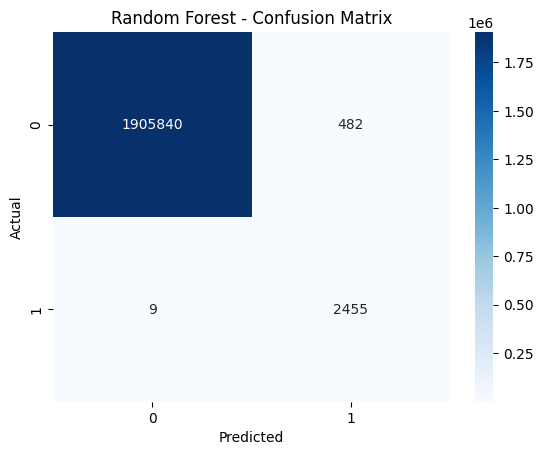

In [ ]:
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"\nROC-AUC Score (Random Forest): {roc_auc_rf:.4f}")


ROC-AUC Score (Random Forest): 0.9997


### Model Interpretation

In [ ]:
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

## What are the key factors that predict fraudulent customer?


Top 10 Most Important Features (Random Forest):
                   feature  importance
8   origBalanceDiscrepancy    0.337749
1            oldbalanceOrg    0.158825
2           newbalanceOrig    0.137993
9   destBalanceDiscrepancy    0.086569
0                   amount    0.074241
13           type_TRANSFER    0.054707
12            type_PAYMENT    0.054331
6        isOrigBalanceZero    0.028796
10           type_CASH_OUT    0.021278
4           newbalanceDest    0.016126


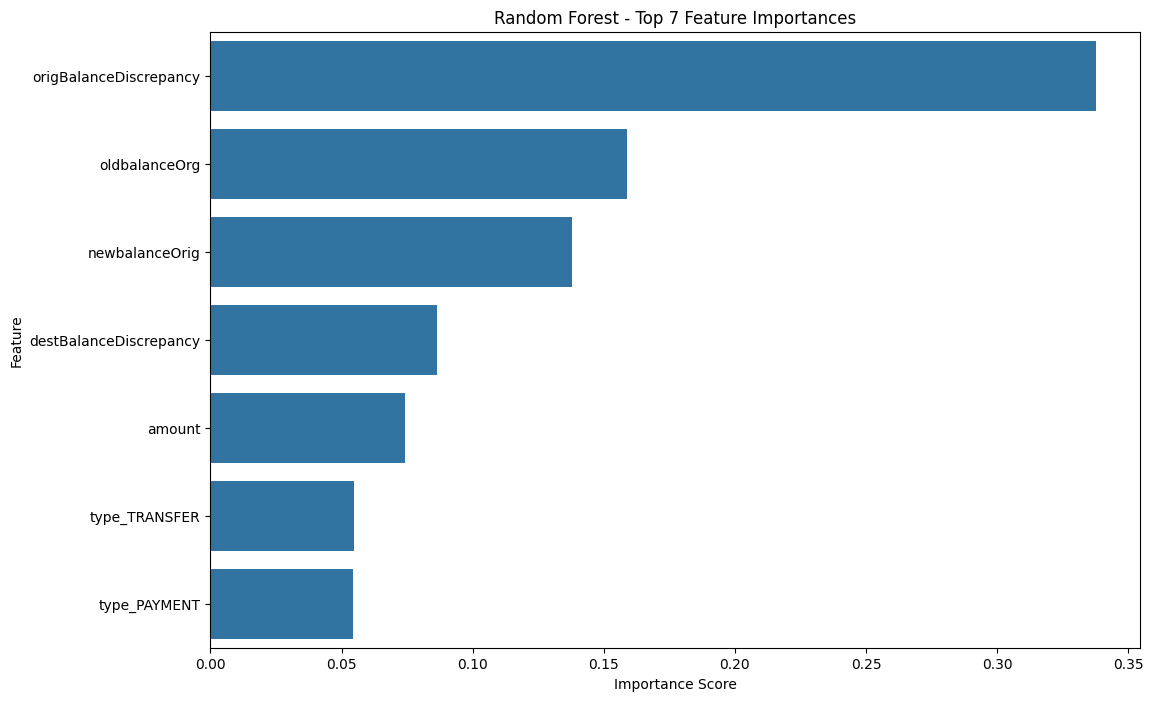

In [ ]:
print("\nTop 10 Most Important Features (Random Forest):")
print(feature_importance_df.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(7))
plt.title('Random Forest - Top 7 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

## Artificial Neural network

In [ ]:
nn_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(name='recall')])
nn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,025 (4.00 KB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\nTraining the Neural Network...")
history = nn_model.fit(
    X_train_scaled,
    y_train_resampled,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1 # Set to 1 to see epoch-by-epoch progress
)
print("Neural Network training complete.")


Training the Neural Network...
Epoch 1/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7571 - loss: 0.4584 - recall: 0.3989 - val_accuracy: 0.9500 - val_loss: 0.2545 - val_recall: 0.9500
Epoch 2/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9251 - loss: 0.1841 - recall: 0.8827 - val_accuracy: 0.9061 - val_loss: 0.2142 - val_recall: 0.9061
Epoch 3/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9456 - loss: 0.1342 - recall: 0.9281 - val_accuracy: 0.9078 - val_loss: 0.1745 - val_recall: 0.9078
Epoch 4/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9537 - loss: 0.1146 - recall: 0.9375 - val_accuracy: 0.9813 - val_loss: 0.1498 - val_recall: 0.9813
Epoch 5/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9548 - loss: 0.1184 - recall: 0.9572 - val_accuracy: 0.8987 - val_loss: 0.1845 - val_recall: 0.8987
Epoch 6/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9528 - loss: 0.1097 - recall: 0.9464 - val_accuracy: 0.9774 - val_loss: 

### Evaluation

59650/59650 ━━━━━━━━━━━━━━━━━━━━ 70s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98   1906322
           1       0.04      0.99      0.07      2464

    accuracy                           0.97   1908786
   macro avg       0.52      0.98      0.53   1908786
weighted avg       1.00      0.97      0.98   1908786

Confusion Matrix:


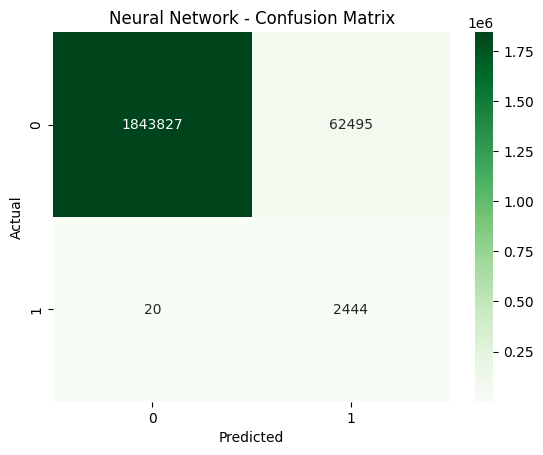

In [ ]:
y_pred_proba_nn = nn_model.predict(X_test_scaled).flatten()
y_pred_nn = (y_pred_proba_nn > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn))

print("Confusion Matrix:")
cm_nn = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Greens')
plt.title('Neural Network - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
roc_auc_nn = roc_auc_score(y_test, y_pred_proba_nn)
print(f"\nROC-AUC Score (Neural Network): {roc_auc_nn:.4f}")


ROC-AUC Score (Neural Network): 0.9966


## How did you select variables to be included in the model?
1. **Manual Selection** -  removing the features manually that had no impact on prediction (`step`, `nameOrig` and `nameDest`)
2. **Feature Engineering** - created new variables to mathematically represent fraudulent behavior (`origBalanceDiscrepancy` to flag accounting errors,  `isOrigBalanceZero` to identify suspicious "mule account" activity and one-hot encoded `type` to isolate risky transfer)
3. **Model-based feature importance** - By both Random Forest and Artificial Neural Network as we discussed above

## Demonstrate the performance of the model by using best set of tools.
We used a comprehensive set of evaluation tools to demonstrate the models' performance on the unseen test data:


1.   Classification Report (`accuracy`, `recall`, `f1-score`)
2.   Confusion Matrix
3.   ROC-AUC Score


## What are the key factors that predict fraudulent customer

Based on the Random Forest's feature importance report, the key factors that predict a fraudulent transaction are: <br>
Top 10 Most Important Features (Random Forest):<br>
              **Feature**  (**Importance**)
1.   `origBalanceDiscrepancy` ----->    (0.337749)
2.            `oldbalanceOrg` ----->   (0.158825)
3.           `newbalanceOrig` ----->   (0.137993)
4.   `destBalanceDiscrepancy` ----->   (0.086569)
5.                  `amount`  ----->   (0.074241)
6.           `type_TRANSFER`  ----->   (0.054707)
7.            `type_PAYMENT`  ----->   (0.054331)

## Do these factors make sense? If yes, How? If not, How not?
Yes, these factors make perfect sense as they logically reflect how financial fraud is committed. The top predictors—`Balance Discrepancy` & `Account Balances`—directly represent the act of theft, as fraudulent transactions often aim to empty an account. The model also confirmed that `TRANSFER` and `CASH_OUT` are the primary transaction types used for fraud, aligning with the data dictionary. The importance of amount is also logical, as criminals often attempt to maximize their theft with large transactions.



## What kind of prevention should be adopted while company update its infrastructure?
Based on the model's insights, the company should adopt a multi-layered prevention strategy:

1. **Real-Time Scoring System**: Implement the trained model into the transaction processing pipeline to score every TRANSFER and CASH_OUT in real-time.

2. **Dynamic Rule Engine**: Instead of a simple rule like "flag all transfers over 200,000," create dynamic, intelligent rules based on the model's top predictors. For example:
  *   Flag any transaction where origBalanceDiscrepancy is not zero.
  *   Assign a higher risk score to transactions where newbalanceOrig is zero.

3. **Tiered Intervention**: For transactions that the model flags with a high probability of fraud, trigger an immediate, automated intervention:
  *   **Medium Risk**: Send a multi-factor authentication (MFA) request (e.g., SMS code) to the customer to verify the transaction.
  *   **High Risk**: Temporarily block the transaction and the account, and immediately flag it for review by a human fraud analyst.

## Assuming these actions have been implemented, how would you determine if they work?
To determine if the new prevention measures are effective, we would implement a robust monitoring framework:

1. Track Key Performance Indicators (KPIs):
  *   **Fraud Detection Rate (Recall)**: The percentage of total fraud that is successfully blocked by the new system. We would expect this to be high.
  *   **False Positive Rate**: The percentage of legitimate transactions that are incorrectly flagged. The goal is to keep this low to minimize customer friction.
  *   **Value of Fraud Prevented**: The total monetary value of fraudulent transactions blocked.

2. **A/B Testing**: Roll out the new system to a segment of users (e.g., 10%) and compare their fraud rates against a control group that remains on the old system. This provides clear, statistical evidence of the new system's impact.

3. **Cost-Benefit Analysi**s: Continuously analyze the financial impact. The reduction in financial losses from fraud should significantly outweigh the operational costs of the new system (e.g., analyst time, infrastructure costs).